# Note to TA: ↓↓↓↓↓ CHANGE THIS FIRST ↓↓↓↓↓

In [1]:
TRAIN_DSET_PATH = "./datasets/train.csv"
TEST_DSET_PATH  = "./datasets/test.csv"
OUTPUT_PATH     = "./2020_11_30_a.csv"

# Note to TA: ↑↑↑↑↑ CHANGE THIS FIRST ↑↑↑↑↑

# 0. Functions for cross-validation

summarize:

takes a model and a dataset and prints the F1 score, precision, recall, confusion matrix and ROC-AUC score



cross_validate:

runs stratified k-fold cross validation using a given model and a given dataset

In [2]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

def summarize(model, X, y, modelapi="sklearn"):
    yhat_probs = model.predict_proba(X)[:,1]
    
    print("Confusion matrix:")
    yhat = np.round(yhat_probs)
    print(confusion_matrix(y, yhat))
    print("ROC AUC score:", roc_auc_score(y, yhat_probs))
    print("ROC AUC curve:")
    fpr, tpr, thresholds = roc_curve(y, yhat_probs)
    plt.plot(fpr, tpr, color="red")
    plt.plot(fpr, fpr, color="blue")
    plt.show()

    return roc_auc_score(y, yhat_probs)

def cross_validate(model, n_folds, X, y, modelapi="sklearn"):
    kfcv = StratifiedKFold(n_splits=n_folds)
    i = 0
    validation_roc_auc = []
    for train_indices, test_indices in kfcv.split(X,y):
        print("Round number", i)
        i += 1
        trainset_X = X[train_indices,:]
        testset_X  = X[test_indices,:]
        trainset_y = y[train_indices]
        testset_y  = y[test_indices]
        model.fit(trainset_X, trainset_y)
        print("\n\nTraining:")
        summarize(model,trainset_X, trainset_y)
        print("Testing:")
        validation_roc_auc.append(summarize(model, testset_X, testset_y))
        print(("-"*15))
    validation_roc_auc = np.array(validation_roc_auc)
    print("Mean validation AUROC:", np.mean(validation_roc_auc))
    print("Median validation AUROC:", np.median(validation_roc_auc))
    print("Min validation AUROC:", np.min(validation_roc_auc))
    print("Max validation AUROC:", np.max(validation_roc_auc))

# 1. Preprocessing

Strategy:

A. Drop excess null value columns.

B. Impute the null values in the remaining columns to either:

a. The mode of that class 

b. The value which contextually makes sense for that column. E.g if there is a column battery_type, NA might mean -- no battery.

C. One-hot-encode remaining columns


In a few columns, multiple values have the same semantic meaning, like "Unknown" and "Not specified". These have been combined.

The display-resolution columns could be better engineered into:

i.    The diagonal in inches 

ii.   The aspect ratio (16:9 vs 4:3  etc)
    
iii.  The number of pixels

## 1.0. Pandas and dataset imports

In [3]:
import numpy as np 
import pandas as pd 
import gc

train_dset_df = pd.read_csv(TRAIN_DSET_PATH)
test_dset_df  = pd.read_csv(TEST_DSET_PATH)

train_Y = train_dset_df.HasDetections.to_numpy()

/home/akb/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (28) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1.1. Data entry

The information on imputation etc was originally kept in .csv files, however, for the sake of portability, the resulting information is being entered in the notebook.

preprocessing_df stores whether to keep column as is, label encode, one-hot encode, do something custom, do null value imputation or drop.

imputation_df stores the value which should fill the NAs in a specified column

In [4]:
from io import StringIO

In [5]:
preprocessing_str = """feature_name,keep_as_is,label_encode,one_hot_encode,custom_encode,null_value_impute,drop
MachineIdentifier,0,0,0,0,0,1
ProductName,0,0,1,0,0,0
EngineVersion,0,0,1,0,0,0
AppVersion,0,0,1,0,0,0
AvSigVersion,0,0,1,0,0,0
IsBeta,1,0,0,0,0,0
RtpStateBitfield,0,0,1,0,1,0
IsSxsPassiveMode,1,0,0,0,0,0
DefaultBrowsersIdentifier,0,0,0,0,0,1
AVProductStatesIdentifier,0,0,1,0,1,0
AVProductsInstalled,1,0,0,0,1,0
AVProductsEnabled,1,0,0,0,1,0
HasTpm,1,0,0,0,0,0
CountryIdentifier,0,0,1,0,0,0
CityIdentifier,0,0,0,0,0,1
OrganizationIdentifier,0,0,0,0,0,1
GeoNameIdentifier,0,0,1,0,1,0
LocaleEnglishNameIdentifier,0,0,1,0,0,0
Platform,0,0,1,0,0,0
Processor,0,0,1,0,0,0
OsVer,0,0,1,0,0,0
OsBuild,0,0,1,0,0,0
OsSuite,0,0,1,0,0,0
OsPlatformSubRelease,0,0,1,0,0,0
OsBuildLab,0,0,1,0,1,0
SkuEdition,0,0,1,0,0,0
IsProtected,1,0,0,0,1,0
AutoSampleOptIn,1,0,0,0,0,0
PuaMode,0,0,0,0,0,1
SMode,1,0,0,0,1,0
IeVerIdentifier,0,0,1,0,1,0
SmartScreen,0,0,0,1,1,0
Firewall,1,0,0,0,1,0
UacLuaenable,0,0,1,0,1,0
Census_MDC2FormFactor,0,0,1,0,0,0
Census_DeviceFamily,0,0,1,0,0,0
Census_OEMNameIdentifier,0,0,1,0,1,0
Census_OEMModelIdentifier,0,0,1,0,1,0
Census_ProcessorCoreCount,1,0,0,0,1,0
Census_ProcessorManufacturerIdentifier,0,0,1,0,1,0
Census_ProcessorModelIdentifier,0,0,1,0,1,0
Census_ProcessorClass,0,0,0,0,0,1
Census_PrimaryDiskTotalCapacity,1,0,0,0,1,0
Census_PrimaryDiskTypeName,0,0,0,1,1,0
Census_SystemVolumeTotalCapacity,1,0,0,0,1,0
Census_HasOpticalDiskDrive,1,0,0,0,0,0
Census_TotalPhysicalRAM,1,0,0,0,1,0
Census_ChassisTypeName,0,0,1,0,1,0
Census_InternalPrimaryDiagonalDisplaySizeInInches,1,0,0,0,0,0
Census_InternalPrimaryDisplayResolutionHorizontal,0,0,0,1,1,0
Census_InternalPrimaryDisplayResolutionVertical,0,0,0,1,1,0
Census_PowerPlatformRoleName,0,0,1,0,1,0
Census_InternalBatteryType,0,0,1,0,1,0
Census_InternalBatteryNumberOfCharges,1,0,0,0,1,0
Census_OSVersion,0,0,1,0,0,0
Census_OSArchitecture,0,0,0,0,0,1
Census_OSBranch,0,0,1,0,0,0
Census_OSBuildNumber,0,0,1,0,0,0
Census_OSBuildRevision,0,0,1,0,0,0
Census_OSEdition,0,0,1,0,0,0
Census_OSSkuName,0,0,1,0,0,0
Census_OSInstallTypeName,0,0,1,0,0,0
Census_OSInstallLanguageIdentifier,0,0,1,0,1,0
Census_OSUILocaleIdentifier,0,0,1,0,0,0
Census_OSWUAutoUpdateOptionsName,0,0,1,0,0,0
Census_IsPortableOperatingSystem,1,0,0,0,0,0
Census_GenuineStateName,0,0,1,0,0,0
Census_ActivationChannel,0,0,1,0,0,0
Census_IsFlightingInternal,0,0,0,0,0,1
Census_IsFlightsDisabled,1,0,0,0,1,0
Census_FlightRing,0,0,1,0,0,0
Census_ThresholdOptIn,0,0,0,0,0,1
Census_FirmwareManufacturerIdentifier,0,0,1,0,1,0
Census_FirmwareVersionIdentifier,0,0,0,0,0,1
Census_IsSecureBootEnabled,1,0,0,0,0,0
Census_IsWIMBootEnabled,0,0,0,0,0,1
Census_IsVirtualDevice,1,0,0,0,1,0
Census_IsTouchEnabled,1,0,0,0,0,0
Census_IsPenCapable,1,0,0,0,0,0
Census_IsAlwaysOnAlwaysConnectedCapable,1,0,0,0,1,0
Wdft_IsGamer,1,0,0,0,1,0
Wdft_RegionIdentifier,0,0,1,0,1,0
HasDetections,1,0,0,0,0,0
"""

preprocessing_str_io = StringIO(preprocessing_str)
preprocessing_df = pd.read_csv(preprocessing_str_io)
preprocessing_df.set_index("feature_name", inplace=True)



In [6]:
imputation_str="""col_name,value_to_fill
AVProductStatesIdentifier,53447.0
GeoNameIdentifier,277.0
OsBuildLab,17134.1.amd64fre.rs4_release.180410-1804
IeVerIdentifier,137.0
Census_OEMNameIdentifier,2668.0
Census_OEMModelIdentifier,313586.0
Census_ProcessorModelIdentifier,1998.0
Census_InternalBatteryType,none
Census_FirmwareManufacturerIdentifier,142.0
RtpStateBitfield,7
AVProductsInstalled,0
AVProductsEnabled,1
IsProtected,0
SMode,0
SmartScreen,off
Firewall,0
UacLuaenable,0
Census_ProcessorCoreCount,4
Census_ProcessorManufacturerIdentifier,5
Census_PrimaryDiskTotalCapacity,1000000
Census_PrimaryDiskTypeName,UNKNOWN
Census_SystemVolumeTotalCapacity,600000
Census_TotalPhysicalRAM,40000
Census_ChassisTypeName,UNKNOWN
Census_InternalPrimaryDisplayResolutionHorizontal,1000
Census_InternalPrimaryDisplayResolutionVertical,1000
Census_PowerPlatformRoleName,UNKNOWN
Census_InternalBatteryNumberOfCharges,1096828554
Census_OSInstallLanguageIdentifier,8
Census_IsFlightsDisabled,0
Census_IsVirtualDevice,0
Census_IsAlwaysOnAlwaysConnectedCapable,0
Wdft_IsGamer,0
Wdft_RegionIdentifier,10
"""

imputation_str_io = StringIO(imputation_str)
imputation_df = pd.read_csv(imputation_str_io)


## 1.2. Dropping columns

In [7]:
for column in preprocessing_df.index:
    if(preprocessing_df.loc[column, "drop"] == 1):
        train_dset_df.drop(axis="columns", inplace=True, labels=[column])
        test_dset_df.drop(axis="columns", inplace=True, labels=[column])

## 1.3. Imputing null values

In [8]:
for i in range(len(imputation_df)):
    try:
        imputation_df["value_to_fill"][i] = int(imputation_df["value_to_fill"][i])
    except:
        pass
        

In [9]:
imputation_df.set_index("col_name", inplace=True)

In [10]:
for column in imputation_df.index:
    train_dset_df[column].fillna(imputation_df.value_to_fill[column], inplace=True)
    test_dset_df[column].fillna(imputation_df.value_to_fill[column], inplace=True)


## 1.4. Custom preprocessing some columns before one-hot encoding

### 1.4.1. Smartscreen

In [11]:
train_dset_df.SmartScreen.unique()

array(['off', 'RequireAdmin', 'ExistsNotSet', 'Off', 'Warn', 'Prompt',
       'Block', '&#x02;', '&#x01;', 'On', 'on', 'requireadmin', 'prompt',
       'Enabled'], dtype=object)

In [12]:
train_dset_df.SmartScreen = train_dset_df.SmartScreen.apply(lambda x: x.lower())
train_dset_df.SmartScreen[train_dset_df.SmartScreen == "enabled"] = "on"
train_dset_df.SmartScreen[train_dset_df.SmartScreen == '&#x02;'] = "off"
train_dset_df.SmartScreen[train_dset_df.SmartScreen == '&#x01;'] = "off"

/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after remo

In [13]:
test_dset_df.SmartScreen = test_dset_df.SmartScreen.apply(lambda x: x.lower())
test_dset_df.SmartScreen[test_dset_df.SmartScreen == "enabled"] = "on"
test_dset_df.SmartScreen[test_dset_df.SmartScreen == '&#x02;'] = "off"
test_dset_df.SmartScreen[test_dset_df.SmartScreen == '&#x01;'] = "off"

/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after remo

In [14]:
test_dset_df.SmartScreen.unique()

array(['off', 'requireadmin', 'existsnotset', 'warn', 'block', 'prompt',
       'on'], dtype=object)

### 1.4.2. Census_PrimaryDiskTypeName

In [15]:
train_dset_df.Census_PrimaryDiskTypeName[train_dset_df.Census_PrimaryDiskTypeName == "Unspecified"] = "UNKNOWN"
test_dset_df.Census_PrimaryDiskTypeName[test_dset_df.Census_PrimaryDiskTypeName == "Unspecified"] = "UNKNOWN"

/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/akb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 1.4.3. Census_InternalPrimaryDisplayResolutionHorizontal and Census_InternalPrimaryDisplayResolutionVertical

In [16]:
prod=  list(train_dset_df.Census_InternalPrimaryDisplayResolutionHorizontal.to_numpy() * train_dset_df.Census_InternalPrimaryDisplayResolutionVertical.to_numpy())
quot = list(train_dset_df.Census_InternalPrimaryDisplayResolutionHorizontal.to_numpy()/ train_dset_df.Census_InternalPrimaryDisplayResolutionVertical.to_numpy())
train_dset_df.Census_InternalPrimaryDisplayResolutionHorizontal = prod
train_dset_df.Census_InternalPrimaryDisplayResolutionVertical = quot
train_dset_df.rename(mapper={"Census_InternalPrimaryDisplayResolutionHorizontal": "pixels", "Census_InternalPrimaryDisplayResolutionVertical": "aspect_ratio"}, inplace=True, axis="columns")

In [17]:
prod=  list(test_dset_df.Census_InternalPrimaryDisplayResolutionHorizontal.to_numpy() * test_dset_df.Census_InternalPrimaryDisplayResolutionVertical.to_numpy())
quot = list(test_dset_df.Census_InternalPrimaryDisplayResolutionHorizontal.to_numpy()/ test_dset_df.Census_InternalPrimaryDisplayResolutionVertical.to_numpy())
test_dset_df.Census_InternalPrimaryDisplayResolutionHorizontal = prod
test_dset_df.Census_InternalPrimaryDisplayResolutionVertical = quot
test_dset_df.rename(mapper={"Census_InternalPrimaryDisplayResolutionHorizontal": "pixels", "Census_InternalPrimaryDisplayResolutionVertical": "aspect_ratio"}, inplace=True, axis="columns")

## 1.5. One-hot encoding

### 1.5.1 Separating to-OHE columns and not-to-OHE columns

In [18]:
ohe_column_names = list(preprocessing_df[preprocessing_df.one_hot_encode == 1].index)
ohe_column_names.extend(["Census_PrimaryDiskTypeName", "SmartScreen"])
not_ohe_column_names = [column for column in test_dset_df.columns if column not in ohe_column_names]

train_to_ohe = train_dset_df.loc[:, ohe_column_names]
test_to_ohe = test_dset_df.loc[:,ohe_column_names]

train_to_not_ohe = train_dset_df.loc[:,not_ohe_column_names]
test_to_not_ohe = test_dset_df.loc[:,not_ohe_column_names]


### 1.5.2 Actual encoding step

In [19]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown="ignore", sparse=True)
ohe.fit(train_to_ohe.astype(str))

train_ohe_done = ohe.transform(train_to_ohe.astype(str))
test_ohe_done = ohe.transform(test_to_ohe.astype(str))

### 1.5.3. Recombining (hstack)

In [20]:
import scipy.sparse

train_to_not_ohe = scipy.sparse.csr.csr_matrix(train_to_not_ohe)
test_to_not_ohe = scipy.sparse.csr.csr_matrix(test_to_not_ohe)

train_X = scipy.sparse.hstack([train_to_not_ohe,train_ohe_done])
test_X = scipy.sparse.hstack([test_to_not_ohe,test_ohe_done])

train_X = train_X.tocsr()
test_X = test_X.tocsr()

train_X.data = np.nan_to_num(train_X.data)
test_X.data = np.nan_to_num(test_X.data)



### 1.5.4. Cleanup

In [21]:
train_to_not_ohe = None 
train_to_ohe = None 
test_to_not_ohe = None 
test_to_ohe = None 
train_ohe_done = None 
test_ohe_done = None 
train_dset_df = None 
test_dset_df = None 

In [22]:
[gc.collect() for _ in range(3)]

[0, 0, 0]

# 2. Models

## 2.1. Boosted trees

### 2.1.1 XGBoost

In [23]:
# import xgboost as xgb

In [24]:
# model = xgb.XGBClassifier(n_estimators=1000,max_depth=4,eta=0.2, n_jobs=8)

In [25]:
# cross_validate(model,10, train_X, train_Y)

### 2.1.2 LightGBM

In [26]:
# import lightgbm as lgb

In [27]:
# model = lgb.LGBMClassifier(num_leaves=16, learning_rate=0.07, n_estimators=2000, silent=False)

In [28]:
# cross_validate(model,10, train_X, train_Y)

model = lgb.LGBMClassifier(num_leaves=16, learning_rate=0.07, n_estimators=2000, silent=False)

Mean validation AUROC: 0.7104980044167221

Median validation AUROC: 0.7099132085505903

Min validation AUROC: 0.7066901870409619

Max validation AUROC: 0.7164782489947419

## 2.1.3. Ensembling of strong classifiers

In [29]:
# class CombinedClassifier:
#     def __init__(self, lst_of_base_models):
#         '''
#         ALL models must support predict_proba
#         '''
#         self.lst_of_base_models = lst_of_base_models 
#     def fit(self, X, y):
#         prob_yhats = []
#         print("CombinedClassifier: Training Base Models")
#         i = 0
#         for model in self.lst_of_base_models:
#             print("Base model number",i)
#             i += 1
#             model.fit(X, y)
#     def predict_proba(self, X):
#         print("CombinedClassifier: Predicting From Base Models")
#         i = 0
#         prob_yhats = []
#         for model in self.lst_of_base_models:
#             print("Base model number",i)
#             i += 1
#             prob_yhats.append(model.predict_proba(X)[:,1].tolist())
#         prob_yhats = np.array(prob_yhats).T 
#         return np.hstack([np.mean(prob_yhats, axis=0).reshape(-1, 1),np.mean(prob_yhats, axis=0).reshape(-1, 1)])

In [30]:
# lst_of_base_lgbm_models = []
# lst_of_base_lgbm_models.append(lgb.LGBMClassifier(num_leaves=16, learning_rate=0.07, n_estimators=2000, silent=False))
# lst_of_base_lgbm_models.append(lgb.LGBMClassifier(num_leaves=16, learning_rate=0.05, n_estimators=4000, silent=False))


# model = CombinedClassifier(lst_of_base_lgbm_models)

In [31]:
# cross_validate(model,10, train_X, train_Y)

## 2.1.4. Naive Bayes

In [32]:
# from sklearn.naive_bayes import BernoulliNB

In [33]:
# model = BernoulliNB(alpha=0.001, class_prior=(0.99,0.01))

In [34]:
# cross_validate(model,10, train_X, train_Y)

model = BernoulliNB(alpha=0.001)

Mean validation AUROC: 0.6348403440628336

Median validation AUROC: 0.633551911314667

Min validation AUROC: 0.6298623283861411

Max validation AUROC: 0.643112318557279

## 2.1.5. Decision Tree

In [35]:
# from sklearn.tree import DecisionTreeClassifier

In [43]:
# model = DecisionTreeClassifier(criterion="gini", max_depth=16, min_samples_split=0.00001, min_samples_leaf=0.000001)

Round number 0


Training:
Confusion matrix:
[[431045   3268]
 [ 64816  11828]]
ROC AUC score: 0.7123702733331824
ROC AUC curve:


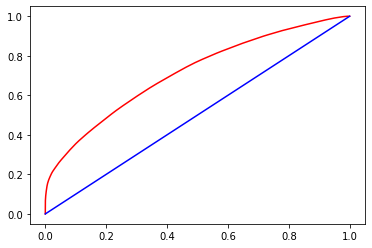

Testing:
Confusion matrix:
[[47502   756]
 [ 7604   911]]
ROC AUC score: 0.6744481809666272
ROC AUC curve:


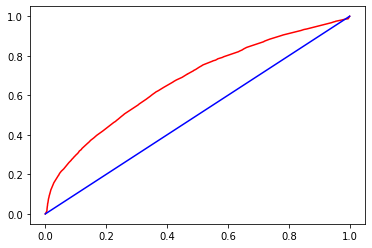

---------------
Round number 1


Training:
Confusion matrix:
[[430419   3895]
 [ 63879  12764]]
ROC AUC score: 0.7139222777033928
ROC AUC curve:


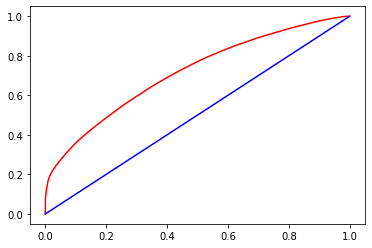

Testing:
Confusion matrix:
[[47440   817]
 [ 7555   961]]
ROC AUC score: 0.668396384141886
ROC AUC curve:


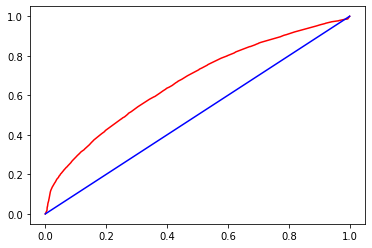

---------------
Round number 2


Training:
Confusion matrix:
[[430176   4138]
 [ 63421  13222]]
ROC AUC score: 0.7137090194126535
ROC AUC curve:


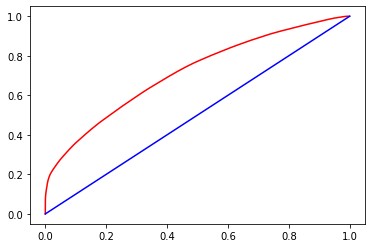

Testing:
Confusion matrix:
[[47436   821]
 [ 7564   952]]
ROC AUC score: 0.6688286730862965
ROC AUC curve:


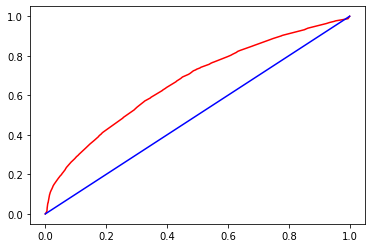

---------------
Round number 3


Training:
Confusion matrix:
[[430504   3810]
 [ 63834  12809]]
ROC AUC score: 0.7130714928119063
ROC AUC curve:


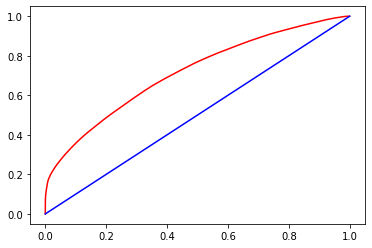

Testing:
Confusion matrix:
[[47458   799]
 [ 7582   934]]
ROC AUC score: 0.6731717398429399
ROC AUC curve:


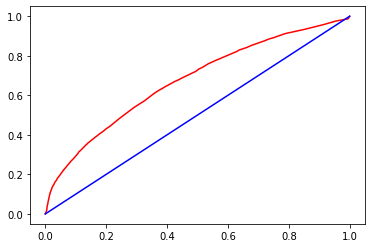

---------------
Round number 4


Training:
Confusion matrix:
[[430754   3560]
 [ 64067  12576]]
ROC AUC score: 0.7147141711968057
ROC AUC curve:


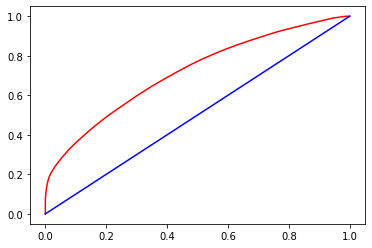

Testing:
Confusion matrix:
[[47448   809]
 [ 7584   932]]
ROC AUC score: 0.6723314212060907
ROC AUC curve:


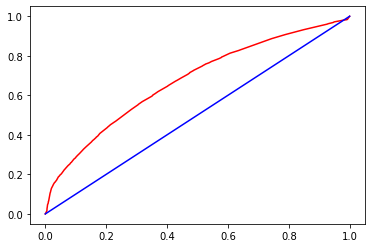

---------------
Round number 5


Training:
Confusion matrix:
[[430684   3630]
 [ 63955  12688]]
ROC AUC score: 0.7143012074968292
ROC AUC curve:


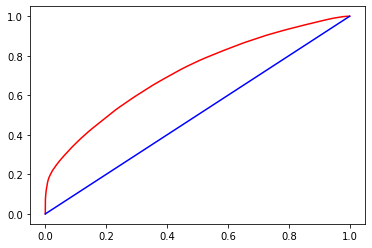

Testing:
Confusion matrix:
[[47434   823]
 [ 7607   909]]
ROC AUC score: 0.6683292481007703
ROC AUC curve:


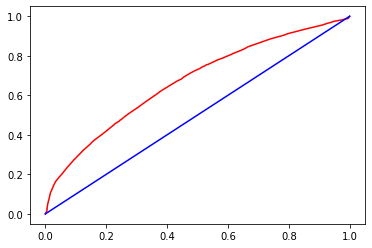

---------------
Round number 6


Training:
Confusion matrix:
[[430439   3875]
 [ 63713  12930]]
ROC AUC score: 0.7143408879854521
ROC AUC curve:


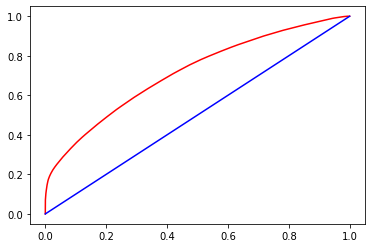

Testing:
Confusion matrix:
[[47379   878]
 [ 7539   977]]
ROC AUC score: 0.6717680223137522
ROC AUC curve:


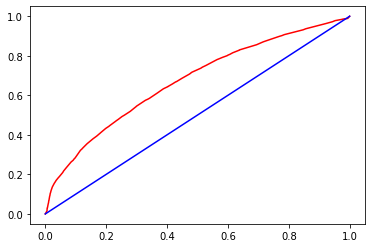

---------------
Round number 7


Training:
Confusion matrix:
[[430307   4007]
 [ 63453  13190]]
ROC AUC score: 0.7145087421336518
ROC AUC curve:


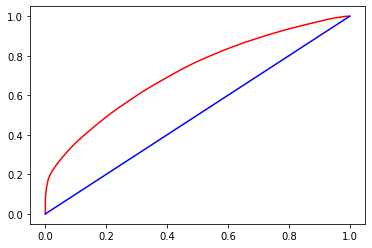

Testing:
Confusion matrix:
[[47364   893]
 [ 7468  1048]]
ROC AUC score: 0.668879790404735
ROC AUC curve:


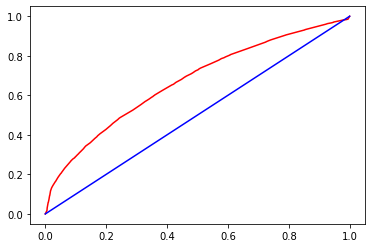

---------------
Round number 8


Training:
Confusion matrix:
[[430582   3732]
 [ 63806  12837]]
ROC AUC score: 0.7143628692751013
ROC AUC curve:


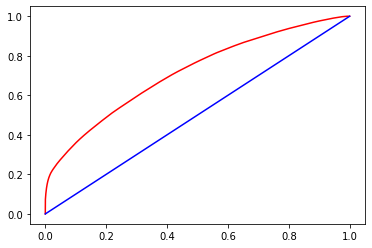

Testing:
Confusion matrix:
[[47398   859]
 [ 7586   930]]
ROC AUC score: 0.6692144753714292
ROC AUC curve:


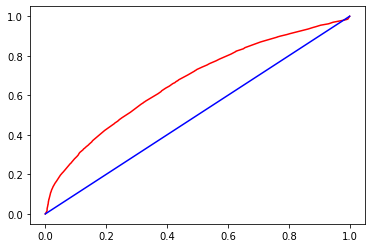

---------------
Round number 9


Training:
Confusion matrix:
[[430860   3454]
 [ 64132  12511]]
ROC AUC score: 0.7154235730433551
ROC AUC curve:


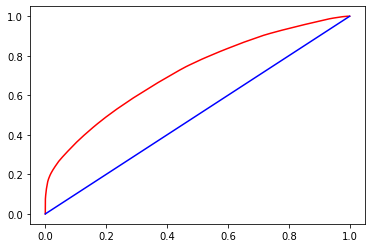

Testing:
Confusion matrix:
[[47421   836]
 [ 7611   905]]
ROC AUC score: 0.6659141269638459
ROC AUC curve:


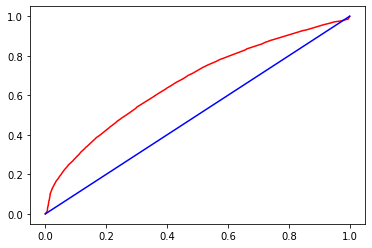

---------------
Mean validation AUROC: 0.6701282062398373
Median validation AUROC: 0.669047132888082
Min validation AUROC: 0.6659141269638459
Max validation AUROC: 0.6744481809666272


In [44]:
# cross_validate(model, 10, train_X, train_Y)

model = DecisionTreeClassifier(criterion="gini", max_depth=12, min_samples_split=0.0001, min_samples_leaf=0.00001, class_weight={0:1,1:1})

Mean validation AUROC: 0.6767119098765395

Median validation AUROC: 0.6759477719511665

Min validation AUROC: 0.6731658888603063

Max validation AUROC: 0.6812523053628827

## 2.1.6. Random Forests

In [45]:
from sklearn.ensemble import RandomForestClassifier

In [52]:
model = RandomForestClassifier(n_estimators=1000, n_jobs=8, max_leaf_nodes=64,verbose=3)

Round number 0
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 1000building tree 2 of 1000
building tree 3 of 1000

building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000building tree 7 of 1000
building tree 8 of 1000

building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    5.1s
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
bui

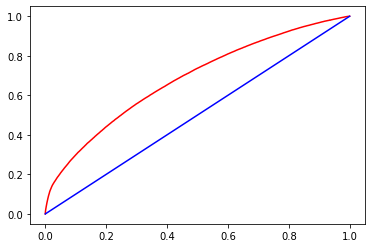

Testing:
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.3s finished
Confusion matrix:
[[48258     0]
 [ 8515     0]]
ROC AUC score: 0.6794643220659206
ROC AUC curve:


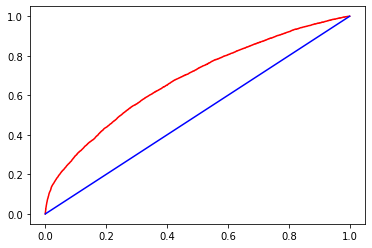

---------------
Round number 1
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 1000building tree 2 of 1000
building tree 3 of 1000

building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000building tree 7 of 1000

building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    6.6s
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tre

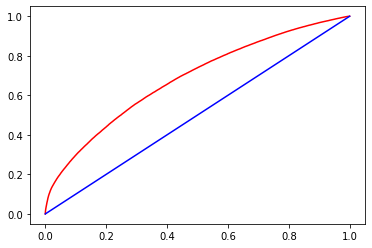

Testing:
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.5s finished
Confusion matrix:
[[48257     0]
 [ 8516     0]]
ROC AUC score: 0.6693948107105768
ROC AUC curve:


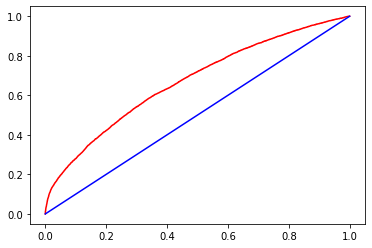

---------------
Round number 2
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 1000
building tree 2 of 1000building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000

building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    7.8s
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tre

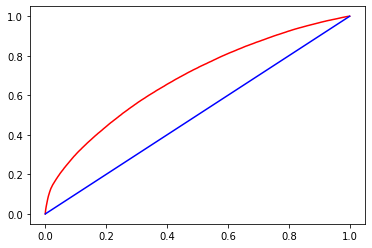

Testing:
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.5s finished
Confusion matrix:
[[48257     0]
 [ 8516     0]]
ROC AUC score: 0.6701746691935448
ROC AUC curve:


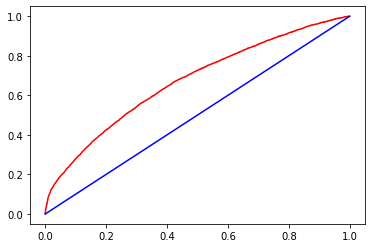

---------------
Round number 3
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000building tree 5 of 1000
building tree 6 of 1000

building tree 7 of 1000building tree 8 of 1000

building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    8.1s
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000building tree 33 of 1000

building tre

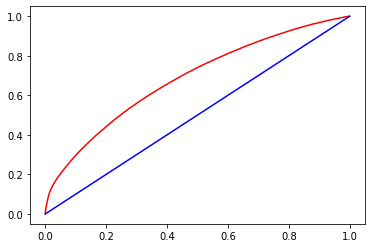

Testing:
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 496 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    2.6s finished
Confusion matrix:
[[48257     0]
 [ 8516     0]]
ROC AUC score: 0.677731583741984
ROC AUC curve:


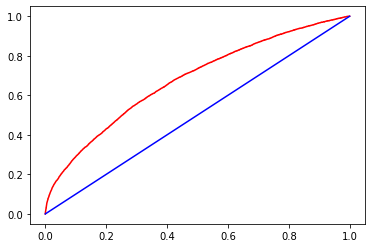

---------------
Round number 4
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
building tree 1 of 1000building tree 2 of 1000building tree 3 of 1000
building tree 4 of 1000


building tree 5 of 1000
building tree 6 of 1000building tree 7 of 1000

building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    6.5s
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tre

KeyboardInterrupt: 

In [53]:
cross_validate(model, 10, train_X, train_Y)

# 3. Testset Write

In [38]:
# model.fit(train_X, train_Y)


In [39]:
# test_Yhat = model.predict_proba(test_X)[:,1]

In [40]:
# test_dset_df  = pd.read_csv("./datasets/test.csv")
# test_dset_df = test_dset_df.loc[:,["MachineIdentifier"]]
# test_dset_df["HasDetections"] = test_Yhat
# test_dset_df.to_csv(OUTPUT_PATH, index=False)